In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Audio
from scipy.io import loadmat

In [24]:
import scienceplots

plt.style.use(["ieee", "no-latex"])

In [25]:
def load_benchmark_data(n_modes, use_single_precision=True, use_tm=False):
    matlab_output = loadmat(
        f"sv_matlab_output_{n_modes:03d}_{'single' if use_single_precision else 'double'}_{'tm' if use_tm else 'vk'}.mat"
    )
    cpp_output = loadmat(
        f"sv_cpp_output_{n_modes:03d}_{'float' if use_single_precision else 'double'}_{'tm' if use_tm else 'vk'}.mat"
    )
    python_output = loadmat(
        f"sv_python_output_{n_modes:03d}_{'single' if use_single_precision else 'double'}_{'tm' if use_tm else 'vk'}.mat"
    )
    pytorch_output = loadmat(
        f"sv_pytorch_output_{n_modes:03d}_{'single' if use_single_precision else 'double'}_gpu_jit_{'tm' if use_tm else 'vk'}.mat"
    )
    # cuda_output = loadmat(f"sv_cuda_output_{n_modes:03d}.mat")

    times_matlab = matlab_output["times_matlab"].reshape(-1)
    times_cpp = cpp_output["times_cpp"].reshape(-1)
    times_python = python_output["times_python"].reshape(-1)
    times_pytorch = pytorch_output["times_pytorch"].reshape(-1)

    data = []
    for implementation, times in [
        ("JAX", times_python),
        ("PyTorch (JIT)", times_pytorch),
        ("Eigen (BLAS)", times_cpp),
        ("MATLAB", times_matlab),
    ]:
        for t in times:
            data.append(
                {
                    "Implementation": implementation,
                    "Time (s)": t,
                    "Modes": n_modes,
                }
            )

    return pd.DataFrame(data)

In [39]:
def plot_combined_benchmark_results(
    df_10_vk, df_50_vk, df_100_vk, df_10_tm, df_50_tm, df_100_tm
):
    # Set the style for publication-quality plots
    font_size = 26  # Slightly larger font for clearer titles
    sns.set_theme(style="whitegrid")
    plt.rcParams.update(
        {
            "font.size": font_size,
            "axes.labelsize": font_size,
            "xtick.labelsize": font_size - 2,
            "ytick.labelsize": font_size - 2,
            "legend.fontsize": font_size - 4,
        }
    )

    # Create a figure with six subplots arranged in 2 rows, 3 columns
    fig, axes = plt.subplots(2, 3, figsize=(20, 24), sharex=True, sharey=True)

    # Determine shared y-axis limits across all datasets
    all_dataframes = [df_10_vk, df_50_vk, df_100_vk, df_10_tm, df_50_tm, df_100_tm]
    min_time = min(df["Time (s)"].min() for df in all_dataframes if not df.empty)
    max_time = max(df["Time (s)"].max() for df in all_dataframes if not df.empty)

    # Add some padding for log scale
    min_time = min_time * 0.4
    max_time = max_time * 2.5

    # Group the dataframes and titles
    top_row_dfs = [df_10_vk, df_50_vk, df_100_vk]
    bottom_row_dfs = [df_10_tm, df_50_tm, df_100_tm]
    titles = ["10 Modes", "50 Modes", "100 Modes"]

    # Plot top row (without TM) - no titles on these
    for i, df in enumerate(top_row_dfs):
        sns.boxplot(
            x="Implementation",
            y="Time (s)",
            data=df,
            palette="muted",
            ax=axes[0, i],
            fliersize=0,
            linewidth=1.5,
            width=0.6,
        )

        # Only show "von Karman" in small text in top left
        if i == 0:
            axes[0, i].text(
                0.05,
                0.95,
                "von Karman",
                ha="left",
                va="top",
                transform=axes[0, i].transAxes,
                fontsize=font_size - 4,
                style="italic",
            )

        # Remove title from top row plots
        axes[0, i].set_title("")

        axes[0, i].set_yscale("log")
        axes[0, i].set_xlabel("")

        # Only include y-label on the leftmost plot of each row
        if i == 0:
            axes[0, i].set_ylabel("Time (s)")
        else:
            axes[0, i].set_ylabel("")

    # Plot bottom row (with TM) - no titles on these either
    for i, df in enumerate(bottom_row_dfs):
        sns.boxplot(
            x="Implementation",
            y="Time (s)",
            data=df,
            palette="muted",
            ax=axes[1, i],
            fliersize=0,
            linewidth=1.5,
            width=0.6,
        )

        # Only show "Tension Modulation" in small text in top left
        if i == 0:
            axes[1, i].text(
                0.05,
                0.95,
                "Berger",
                ha="left",
                va="top",
                transform=axes[1, i].transAxes,
                fontsize=font_size - 4,
                style="italic",
            )

        # Remove title from bottom row plots
        axes[1, i].set_title("")

        axes[1, i].set_yscale("log")
        axes[1, i].set_xlabel("")

        # Only include y-label on the leftmost plot of each row
        if i == 0:
            axes[1, i].set_ylabel("Time (s)")
        else:
            axes[1, i].set_ylabel("")

    # Add column titles at the top of the figure
    for i, title in enumerate(titles):
        fig.text(
            0.22 + i * 0.29,  # Position horizontally (adjust as needed for your layout)
            0.96,  # Position at the top
            title,
            ha="center",
            va="top",
            fontsize=font_size + 2,
            fontweight="bold",
        )

    # Set the same y-axis limits for all plots and add horizontal reference line
    for row in axes:
        for ax in row:
            ax.set_ylim(min_time, max_time)

            # Add horizontal line at 1 second to indicate sequence time
            ax.axhline(y=1.0, color="r", linestyle="--", linewidth=1.5, alpha=0.7)

            # Add a text annotation for the reference line
            ax.text(
                ax.get_xlim()[1] * 0.98,
                1.05,
                "Sequence duration (1s)",
                ha="right",
                va="bottom",
                color="r",
                fontsize=font_size - 6,  # Smaller font for annotation
                bbox=None,
            )

            # Improve the appearance
            ax.grid(True, alpha=0.3)
            plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
            ax.yaxis.grid(True, linestyle="-", alpha=0.2)
            ax.tick_params(axis="both", which="both", length=0)

            # Adjust the plot size to better accommodate the boxes
            for tick in ax.xaxis.get_major_ticks():
                tick.set_pad(8)  # Slightly reduced padding

    # Create tight layout with better spacing between rows/columns
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave room for the column titles
    fig.subplots_adjust(
        hspace=0.15, wspace=0.05
    )  # Reduced vertical space between plots

    # Save figure
    plt.savefig("benchmark_comparison.eps", bbox_inches="tight", format="eps")
    plt.show()


# Load the data for both methods
df_10_vk = load_benchmark_data(10, use_tm=False)
df_50_vk = load_benchmark_data(50, use_tm=False)
df_100_vk = load_benchmark_data(100, use_tm=False)

df_10_tm = load_benchmark_data(10, use_tm=True)
df_50_tm = load_benchmark_data(50, use_tm=True)
df_100_tm = load_benchmark_data(100, use_tm=True)

# Create the combined plot
plot_combined_benchmark_results(
    df_10_vk, df_50_vk, df_100_vk, df_10_tm, df_50_tm, df_100_tm
)

/tmp/ipykernel_57456/2096100412.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_57456/2096100412.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_57456/2096100412.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_57456/2096100412.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_57456/2096100412.py:71: FutureWarning

In [30]:
n_modes = 10
matlab_output = loadmat(f"sv_matlab_output_{n_modes:03d}.mat")
cpp_output = loadmat(f"sv_cpp_output_{n_modes:03d}.mat")
python_output = loadmat(f"sv_python_output_{n_modes:03d}.mat")
pytorch_output = loadmat(f"sv_pytorch_output_{n_modes:03d}_single_gpu_jit.mat")

out_pos_matlab = matlab_output["out_pos_matlab"].reshape(-1)
times_matlab = matlab_output["times_matlab"].reshape(-1)

out_pos_cpp = cpp_output["out_pos_cpp"].reshape(-1)
times_cpp = cpp_output["times_cpp"].reshape(-1)

out_pos_python = python_output["out_pos_python"].reshape(-1)
times_python = python_output["times_python"].reshape(-1)

out_pos_pytorch = pytorch_output["out_pos_pytorch"].reshape(-1)
times_pytorch = pytorch_output["times_pytorch"].reshape(-1)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(out_pos_python, label="gt")
ax.plot(out_pos_matlab, label="matlab", linestyle="--")
ax.plot(out_pos_cpp, label="cpp", linestyle="-.")
ax.plot(out_pos_pytorch, label="pytorch", linestyle=":")
ax.set_xlim(0, 4410)
ax.legend()
display(Audio(out_pos_matlab, rate=44100))

FileNotFoundError: [Errno 2] No such file or directory: 'sv_matlab_output_010.mat'

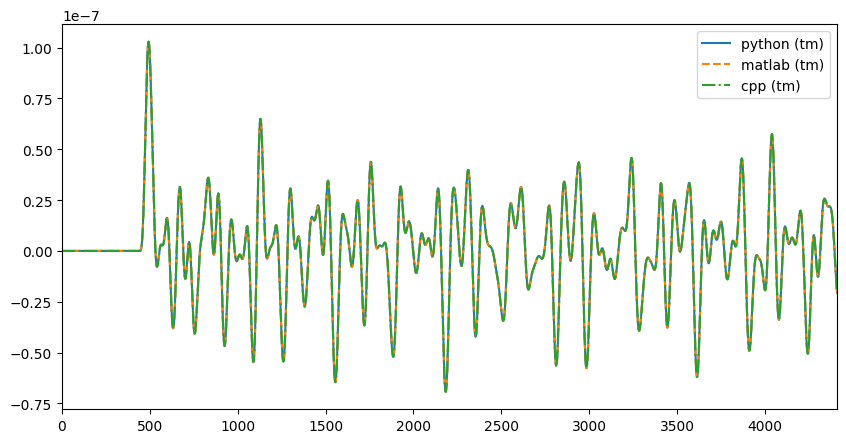

In [18]:
n_modes = 10
use_tm = True
use_single_precision = True

python_output = loadmat(
    f"sv_python_output_{n_modes:03d}_{'single' if use_single_precision else 'double'}_{'tm' if use_tm else 'vk'}.mat"
)
matlab_output = loadmat(
    f"sv_matlab_output_{n_modes:03d}_{'single' if use_single_precision else 'double'}_{'tm' if use_tm else 'vk'}.mat"
)
cpp_output = loadmat(
    f"sv_cpp_output_{n_modes:03d}_{'float' if use_single_precision else 'double'}_{'tm' if use_tm else 'vk'}.mat"
)
out_pos_python = python_output["out_pos_python"].reshape(-1)
out_pos_matlab = matlab_output["out_pos_matlab"].reshape(-1)
out_pos_cpp = cpp_output["out_pos_cpp"].reshape(-1)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(out_pos_python, label="python (tm)")
ax.plot(out_pos_matlab, label="matlab (tm)", linestyle="--")
ax.plot(out_pos_cpp, label="cpp (tm)", linestyle="-.")
ax.set_xlim(0, 4410)
ax.legend()
display(Audio(out_pos_python, rate=44100))
display(Audio(out_pos_matlab, rate=44100))
display(Audio(out_pos_cpp, rate=44100))